In [1]:
import boolean2
import pylab

# Introduction to BooleanNet

## Define a model with its initial condition

In [2]:
## This initial condition leads to a cycle of period 4.
## If A is set to False, a steady state is obtained.
text = """
A = D = True
B = C = False

B *= A or C
C *= A and not D
D *= B and C
"""

model = boolean2.Model( text=text, mode='sync')
model.initialize()

## Simulations

In [3]:
model.iterate( steps=15 )

In [4]:
## the model data attribute holds the states keyed by nodes
for node in model.data:
    print(node, model.data[node])

A [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
B [False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
C [False, False, True, True, False, False, True, True, False, False, True, True, False, False, True, True]
D [True, False, False, True, True, False, False, True, True, False, False, True, True, False, False, True]


In [5]:
## Successive states are also available
for state in model.states:
    print(state.A, state.B, state.C, state.D)

True False False True
True True False False
True True True False
True True True True
True True False True
True True False False
True True True False
True True True True
True True False True
True True False False
True True True False
True True True True
True True False True
True True False False
True True True False
True True True True


### Cycle detection

In [6]:
## this is a helper function that reports the cycle lengths 
## and the  index at wich the cycle started
model.report_cycles()

Cycle of length 4 starting at index 1


In [7]:
## the same thing as above but
## will not print only return the two parameters
model.detect_cycles()

(1, 4)

### Plot of a trajectory

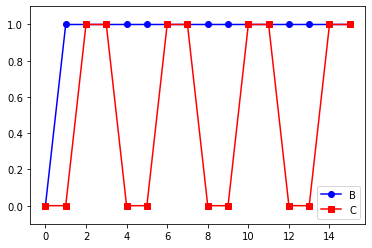

In [8]:
p1 = pylab.plot( model.data["B"] , 'ob-', label="B" )
p2 = pylab.plot( model.data["C"] , 'sr-', label="C" )
pylab.legend()

pylab.ylim((-0.1,1.1))
pylab.show()    

### Random sampling of the initial condition

In [9]:
text = """
A = True
B = Random
C = Random
D = Random

B *= A or C
C *= A and not D
D *= B and C
"""

seen = {}

 
## the key will be the fingerprint of the first state 
##(some random inital conditions may be the same), it is fine to overwrite in this case
## as the 'sync' update rule is completely deterministic
for i in range(10):
    model = boolean2.Model( text=text, mode='sync')
    model.initialize()
    model.iterate( steps=20 )

    # detect the cycles in the states
    size, index = model.detect_cycles() 
    
    # fingerprint of the first state
    key = model.first.fp()

    # keep only the first 10 states out of the 20
    values = [ x.fp() for x in model.states[:10] ]

    # store the fingerprinted values for each initial state
    seen [ key ] = (index, size, values )

## print out the observed states
for first, values in list(seen.items()):
    print('Start: %s -> %s' % (first, values))

Start: 1 -> (4, 0, [1, 2, 3, 4, 1, 2, 3, 4, 1, 2])
Start: 3 -> (4, 0, [3, 4, 1, 2, 3, 4, 1, 2, 3, 4])
Start: 2 -> (4, 0, [2, 3, 4, 1, 2, 3, 4, 1, 2, 3])
Start: 5 -> (4, 1, [5, 2, 3, 4, 1, 2, 3, 4, 1, 2])
Start: 6 -> (4, 1, [6, 2, 3, 4, 1, 2, 3, 4, 1, 2])
Start: 7 -> (4, 1, [7, 1, 2, 3, 4, 1, 2, 3, 4, 1])
Start: 0 -> (4, 1, [0, 1, 2, 3, 4, 1, 2, 3, 4, 1])


### Perturbation (KO, KI) of the model

In [10]:
## Knocking node B out.
##
## Instead of a cycle, now a steady state is observed.
## 
## Code is identical to tutorial 3 after the state modification steps

text = """
A = True
B = Random
C = Random
D = Random

B *= A or C
C *= A and not D
D *= B and C
"""


## Fix the value and initial states of some components (here we perform a KO of B)
text = boolean2.modify_states(text, turnon=[], turnoff=[ "B" ])


seen = {}
for i in range(10):
    model = boolean2.Model( text, mode='sync')
    model.initialize()
    model.iterate( steps=20 )

    size, index = model.detect_cycles() 
    
    # fingerprint of the first state
    key = model.first.fp()

    # keep only the first 10 states out of the 20
    values = [ x.fp() for x in model.states[:10] ]

    # store the fingerprinted values for each initial state
    seen [ key ] = (index, size, values )   

## print out the observed states
for first, values in list(seen.items()):
    print('Start: %s -> %s' % (first, values))

Start: 5 -> (1, 1, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6])
Start: 0 -> (1, 2, [0, 5, 6, 6, 6, 6, 6, 6, 6, 6])
Start: 6 -> (1, 0, [6, 6, 6, 6, 6, 6, 6, 6, 6, 6])


### Random sampling of asynchronous trajectories

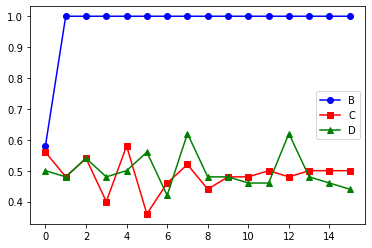

In [11]:
## Asynchronous updating rules are non deterministic and
## need to be averaged over many runs
##
## The collector class makes this averaging very easy. It takes
## a list of states and nodes to build a data structure that 
## can compute the average the state of each node over all simulation and each timestep.
##
## The output of averaging (in the normalized mode) is a value between
## 0 and 1 representing the fraction of simulation (multiply by 100 to get percent) 
## that had the node in state True. 


text = """
A = True
B = Random
C = Random
D = Random
B* = A or C
C* = A and not D
D* = B and C
"""

coll  = boolean2.util.Collector()
for i in range(50):
    model = boolean2.Model( text, mode='async')
    model.initialize()
    model.iterate( steps=15 ) 

    # in this case we take all nodes
    # one could just list a few nodes such as [ 'A', 'B', 'C' ]
    nodes = model.nodes

    # this collects states for each run
    coll.collect( states=model.states, nodes=nodes )

## this step averages the values for each node
## returns a dictionary keyed by nodes and a list of values
## with the average state for in each timestep
avgs = coll.get_averages( normalize=True )

## make some shortcut to data to for easier plotting
valueB = avgs["B"]
valueC = avgs["C"]
valueD = avgs["D"]

## plot the state of the nodes
p1 = pylab.plot( valueB , 'ob-', label="B" )
p2 = pylab.plot( valueC , 'sr-', label="C" )
p3 = pylab.plot( valueD , '^g-', label="D" )
pylab.legend()

pylab.show()

## PLDE mode (broken with newer versions of pylab)

In addition to sync and async modes, booleannet supports a PLDE mode.
Unfortunately, it relies on the RK integrator which used to be part of pylab but has been removed.

In [12]:
## Using Piecewise linear differential equations
##
## This initial condition leads to damped oscillations
## If A is set to False, a steady state is obtained.

text = """
A = True
B = False
C = False
D = True
1: B* = A or C
1: C* = A and not D
1: D* = B and C
"""

if False:
    model = boolean2.Model( text, mode='plde')
    model.initialize()
    model.iterate( fullt=7, steps=150 )

    #
    # generate the plot
    #
    p1 = pylab.plot( model.data["B"] , 'ob-' )
    p2 = pylab.plot( model.data["C"] , 'sr-' )
    p3 = pylab.plot( model.data["D"] , '^g-' )


    pylab.legend( [p1,p2,p3], ["B","C","D"])

    pylab.show()